##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# pix2pix: Image-to-image translation with a conditional GAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to build and train a conditional generative adversarial network (cGAN) called pix2pix that learns a mapping from input images to output images, as described in [Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004){:.external} by Isola et al. (2017). pix2pix is not application specific—it can be applied to a wide range of tasks, including synthesizing photos from label maps, generating colorized photos from black and white images, turning Google Maps photos into aerial images, and even transforming sketches into photos.

In this example, your network will generate images of building facades using the [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/) provided by the [Center for Machine Perception](http://cmp.felk.cvut.cz/){:.external} at the [Czech Technical University in Prague](https://www.cvut.cz/){:.external}. To keep it short, you will use a [preprocessed copy](https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/){:.external} of this dataset created by the pix2pix authors.

In the pix2pix cGAN, you condition on input images and generate corresponding output images. cGANs were first proposed in [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) (Mirza and Osindero, 2014)

The architecture of your network will contain:

- A generator with a [U-Net](https://arxiv.org/abs/1505.04597){:.external}-based architecture.
- A discriminator represented by a convolutional PatchGAN classifier (proposed in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}).

Note that each epoch can take around 15 seconds on a single V100 GPU.

Below are some examples of the output generated by the pix2pix cGAN after training for 200 epochs on the facades dataset (80k steps).

![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png)
![sample output_2](https://www.tensorflow.org/images/gan/pix2pix_2.png)

## Import TensorFlow and other libraries

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf

import os
import pathlib
import time
from datetime import datetime

from utils import fast_tensor_load_encdec


from matplotlib import pyplot as plt
from IPython import display

2023-07-21 09:21:00.811374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 09:21:16.472737: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-21 09:21:18.553096: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-07-21 09:21:18

In [4]:
var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu', 'VrfSPS']
# Initialize parameters
data_dir = './tomo_data/datasets_tomoscope_TF_24-03-23/'

timestamp = datetime.now().strftime("%Y_%m_%d_%H-%M-%S")
timestamp = 'pix2pix_test'
print('Using timestamp: ', timestamp)


# Train specific
train_cfg = {
    'epochs': 10, 'output_turns': 1,
    'cropping': [0, 0],
    'enc_dense_layers': [1024, 256],
    'dec_dense_layers': [1024],
    'enc_filters': [4, 8, 16],
    'dec_filters': [8, 16, 10],
    'enc_kernel_size': 3,
    'dec_kernel_size': 3,
    'enc_strides': [2, 2],
    'dec_strides': [2, 2],
    'enc_activation': 'relu',
    'dec_activation': 'relu',
    'enc_pooling': None, 'dec_pooling': None,
    'enc_pooling_size': [0, 0], 'dec_pooling_size': [0, 0],
    'enc_pooling_strides': [1, 1], 'dec_pooling_strides': [1, 1],
    'enc_pooling_padding': 'valid', 'dec_pooling_padding': 'valid',
    'enc_dropout': 0.0, 'dec_dropout': 0.0,
    'metrics': [], 'use_bias': False, 'batchnorm': False,
    'learning_rate': 1e-3,
    'dataset%': 0.01,
    'normalization': 'minmax', 'img_normalize': 'off',
    'ps_normalize': 'off',
    'batch_size': 32
}

Using timestamp:  pix2pix_test


## Load the dataset

Download the CMP Facade Database data (30MB). Additional datasets are available in the same format [here](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/){:.external}. In Colab you can select other datasets from the drop-down menu. Note that some of the other datasets are significantly larger (`edges2handbags` is 8GB in size). 

In [49]:
# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
assert os.path.exists(ML_dir)

TRAINING_PATH = os.path.join(ML_dir, 'TRAINING')
VALIDATION_PATH = os.path.join(ML_dir, 'VALIDATION')

# create the directory to store the results
os.makedirs(trial_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)


assert train_cfg['normalization'] == 'minmax'
assert train_cfg['img_normalize'] == 'off'
assert train_cfg['ps_normalize'] == 'off'

TRAINING_PATH = os.path.join(ML_dir, 'tomoscope-training-??.npz')
VALIDATION_PATH = os.path.join(ML_dir, 'tomoscope-validation-??.npz')

x_train, turn_train, latent_train, y_train = fast_tensor_load_encdec(
    TRAINING_PATH, train_cfg['dataset%'])
print('Number of Training files: ', len(y_train))

x_valid, turn_valid, latent_valid, y_valid = fast_tensor_load_encdec(
    VALIDATION_PATH, train_cfg['dataset%'])
print('Number of Validation files: ', len(y_valid))

Loading ./tomo_data/datasets_tomoscope_TF_24-03-23/ML_data/tomoscope-training-00.npz
Loading ./tomo_data/datasets_tomoscope_TF_24-03-23/ML_data/tomoscope-training-01.npz
Loading ./tomo_data/datasets_tomoscope_TF_24-03-23/ML_data/tomoscope-training-02.npz
Loading ./tomo_data/datasets_tomoscope_TF_24-03-23/ML_data/tomoscope-training-03.npz
Number of Training files:  158
Loading ./tomo_data/datasets_tomoscope_TF_24-03-23/ML_data/tomoscope-validation-00.npz
Number of Validation files:  14


In [50]:
# Keep only the first turns
y_train = y_train[:, :, :, :train_cfg['output_turns']]
y_valid = y_valid[:, :, :, :train_cfg['output_turns']]

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.batch(1)
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
valid_ds = valid_ds.batch(1)

print('Training data shape: ', x_train.shape, y_train.shape)
print('turns data shape: ', turn_train.shape)
print('latent data shape: ', latent_train.shape)



Training data shape:  (158, 128, 128, 1) (158, 128, 128, 1)
turns data shape:  (158, 10)
latent data shape:  (158, 7)


## Build the generator

The generator of your pix2pix cGAN is a _modified_ [U-Net](https://arxiv.org/abs/1505.04597){:.external}. A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the [Image segmentation](../images/segmentation.ipynb) tutorial and on the [U-Net project website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/){:.external}.)

- Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
- Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

Define the downsampler (encoder):

In [7]:
OUTPUT_CHANNELS = 1

In [16]:
def downsample(filters, size, apply_batchnorm=True, name=None):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential(name=name)
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [51]:
inp = x_train[:1]
down_model = downsample(3, 4)
down_result = down_model(inp)
print(down_result.shape)

(1, 64, 64, 3)


Define the upsampler (decoder):

In [52]:
def upsample(filters, size, apply_dropout=False, name=None):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential(name=name)
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [53]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 128, 128, 3)


Define the generator with the downsampler and the upsampler:

In [54]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])

    down_stack = [
        downsample(32, 4, apply_batchnorm=False, name='encoder_1'),  # (batch_size, 64, 64, 32)
        downsample(64, 4, name='encoder_2'),  # (batch_size, 32, 32, 64)
        downsample(128, 4, name='encoder_3'),  # (batch_size, 16, 16, 128)
        downsample(256, 4, name='encoder_4'),  # (batch_size, 8, 8, 256)
        downsample(256, 4, name='encoder_5'),  # (batch_size, 4, 4, 256)
        downsample(256, 4, name='encoder_6'),  # (batch_size, 2, 2, 256)
        downsample(256, 4, name='encoder_7'),  # (batch_size, 1, 1, 256)
    ]

    up_stack = [
        upsample(256, 4, apply_dropout=True, name='decoder_1'),  # (batch_size, 2, 2, 256)
        upsample(256, 4, apply_dropout=True, name='decoder_2'),  # (batch_size, 4, 4, 256)
        upsample(256, 4, apply_dropout=True, name='decoder_3'),  # (batch_size, 8, 8, 256)
        upsample(128, 4, name='decoder_4'),  # (batch_size, 16, 16, 128)
        upsample(64, 4, name='decoder_5'),  # (batch_size, 32, 32, 64)
        upsample(32, 4, name='decoder_6'),  # (batch_size, 64, 64, 32)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           name='decoder_last',
                                           activation='tanh')  # (batch_size, 128, 128, 1)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for idx, (up, skip) in enumerate(zip(up_stack, skips)):
        x = up(x)
        x = tf.keras.layers.Concatenate(name=f'concatenate_{idx+1}')([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

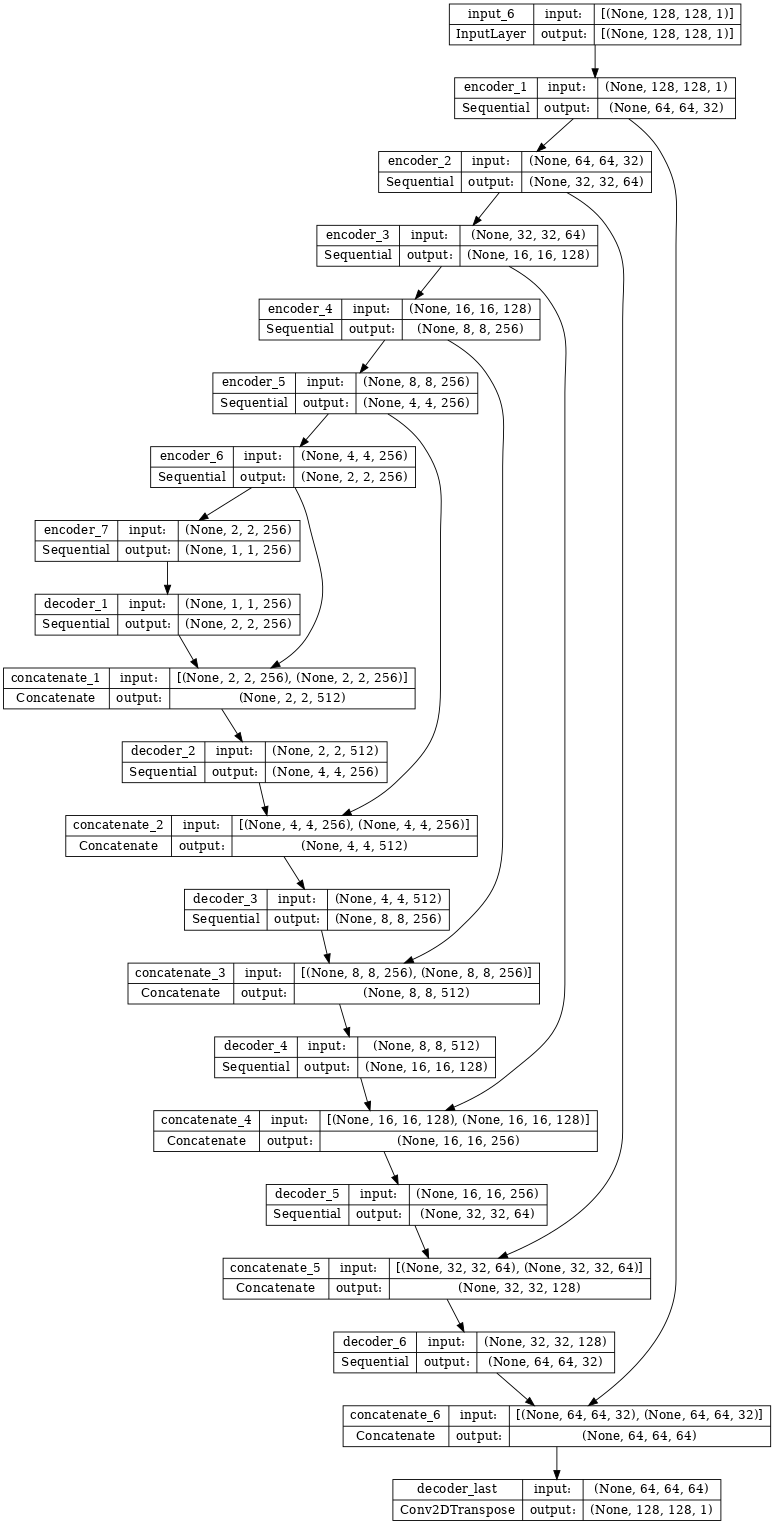

In [55]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test the generator:

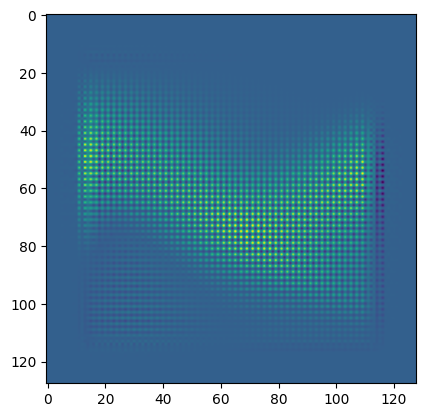

In [56]:
gen_output = generator(x_train[0][tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [57]:
LAMBDA = 100

In [58]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [59]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(
        disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs: 
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

Let's define the discriminator:

In [60]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[128, 128, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[128, 128, 1], name='target_image')

    # (batch_size, 128, 128, channels*2)
    x = tf.keras.layers.concatenate([inp, tar])

    down1 = downsample(32, 4, False, name='discriminator_1')(x)  # (batch_size, 64, 64, 32)
    down2 = downsample(64, 4, name='discriminator_2')(down1)  # (batch_size, 32, 32, 64)
    down3 = downsample(128, 4, name='discriminator_3')(down2)  # (batch_size, 16, 16, 128)

    zero_pad1 = tf.keras.layers.ZeroPadding2D(name='zeropad_1')(down3)  # (batch_size, 18, 18, 128)
    conv = tf.keras.layers.Conv2D(256, 4, strides=1,
                                  kernel_initializer=initializer,
                                  name='conv_1',
                                  use_bias=False)(zero_pad1)  # (batch_size, 15, 15, 256)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D(name='zeropad_2')(
        leaky_relu)  # (batch_size, 17, 17, 256)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  name='conv_final',
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 14, 14, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

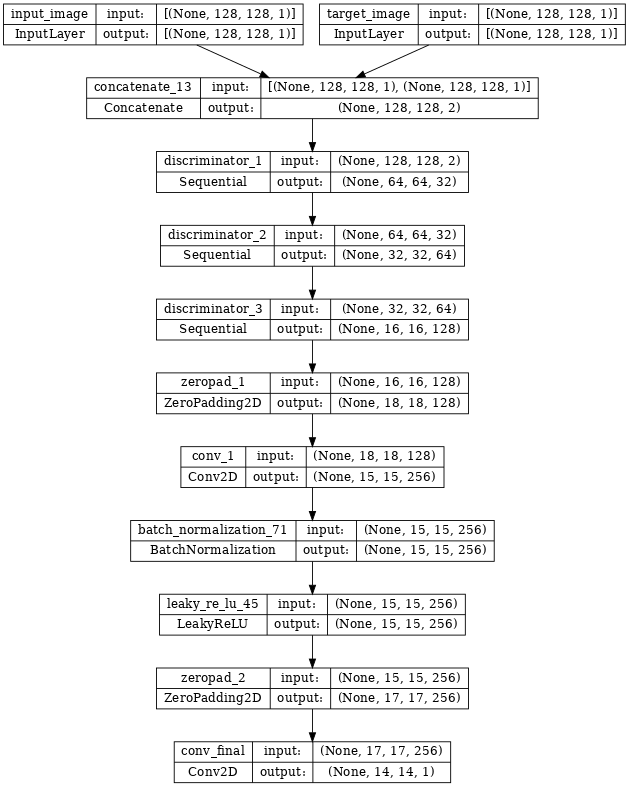

In [61]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

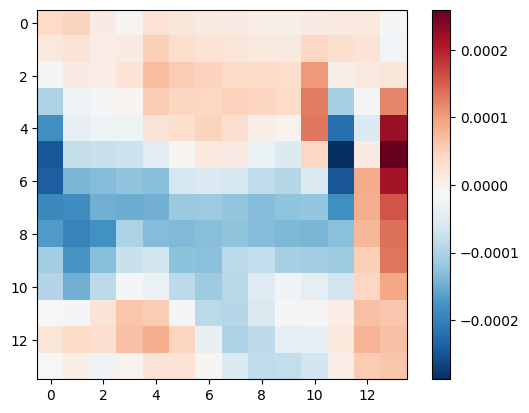

In [62]:
disc_out = discriminator([x_train[0][tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], cmap='RdBu_r')
plt.colorbar()

### Define the discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [63]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(
        disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the optimizers and a checkpoint-saver


In [64]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [65]:
checkpoint_dir = weights_dir
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

Note: The `training=True` is intentional here since you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [66]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

Test the function:

(1, 128, 128, 1)


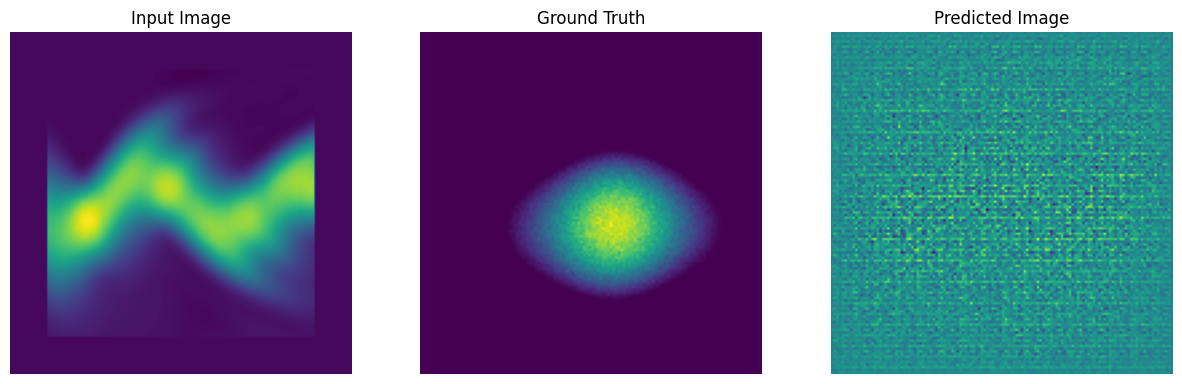

In [67]:
for example_input, example_target in valid_ds.take(1):
    print(example_input.shape)
    generate_images(generator, example_input, example_target)

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [68]:
log_dir = "logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

In [69]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator(
            [input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [70]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(
                    f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)

        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

To launch the viewer paste the following into a code-cell:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Finally, run the training loop:

Time taken for 1000 steps: 109.95 sec



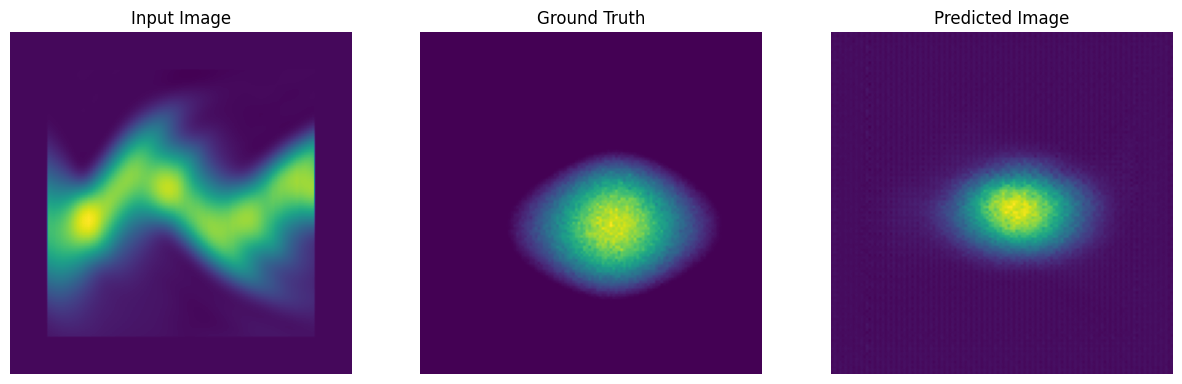

Step: 4k
........

KeyboardInterrupt: 

In [72]:
fit(train_ds, valid_ds, steps=40000)

If you want to share the TensorBoard results _publicly_, you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This requires a Google account.

```
!tensorboard dev upload --logdir {log_dir}
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

[TensorBoard.dev](https://tensorboard.dev){:.external} is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It can also included inline using an `<iframe>`:

In [47]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [44]:
!ls {checkpoint_dir}

checkpoint		    ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-5.index
ckpt-1.index		    ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-2.index		    ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-3.index		    ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-4.index


In [45]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

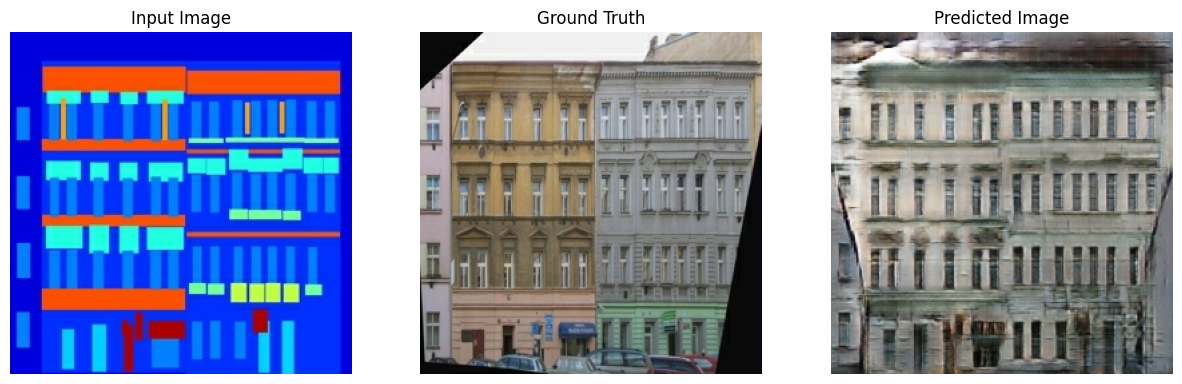

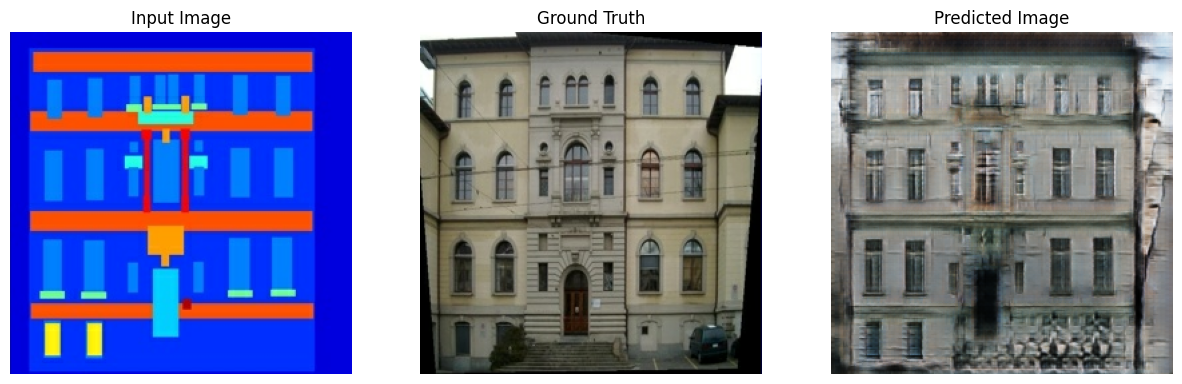

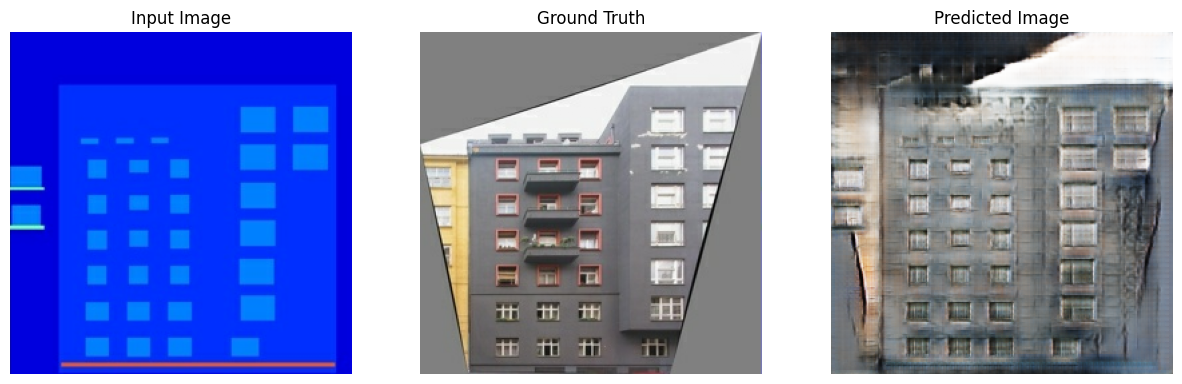

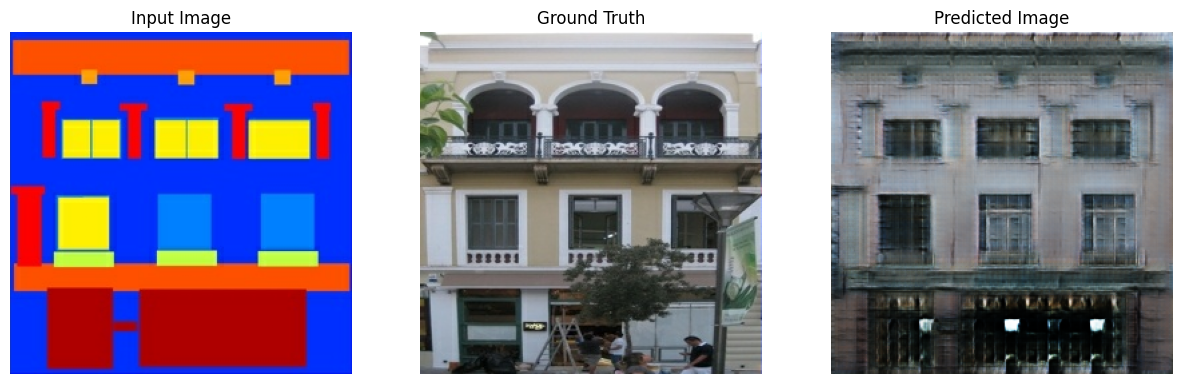

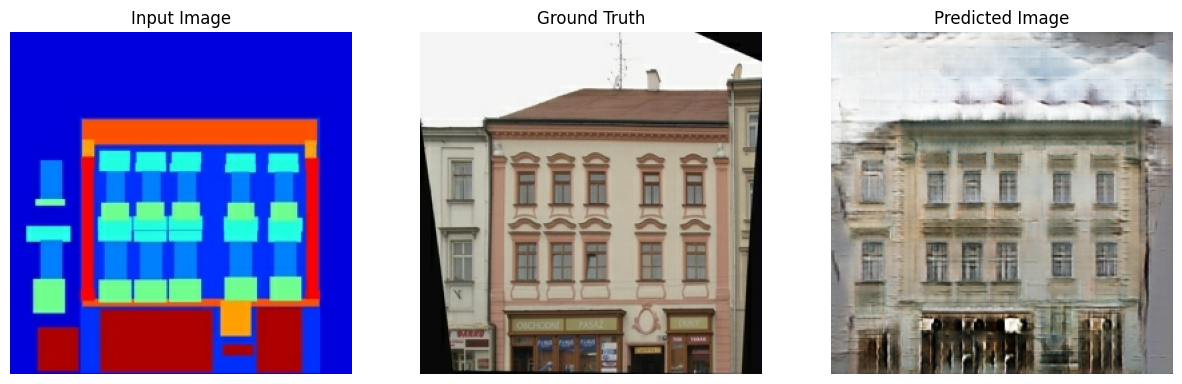

In [46]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)

In [4]:
%load_ext tensorboard
%tensorboard --logdir "trials/2023_07_21_14-47-05/logs"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
!kill 2969033